### Packages

In [3]:
import pickle
import time
from esda.moran import Moran
from esda.moran import Moran_Local
from libpysal.weights import Queen, KNN, W
import seaborn as sb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from clustergram import Clustergram
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
from multiprocessing.pool import ThreadPool 

### Data

In [ ]:
# main gdf
popgridmanchester = gpd.read_file("popgridmanchesterlatest.gpkg")

# subset of variables of interest
popgridsub = popgridmanchester.iloc[:,[4,11,18,21,22,25,27,30,31]+list(range(36,60))]

# variables of interest
cluster_variables = [col for col in popgridsub.columns if col != "geometry"]

# converting pop density to per km^2, will do this for the main gdf
popgridsub.buffer_pop_density = popgridsub.buffer_pop_density*1000000

# remove nans and inf values, resetting index
popgridsub = popgridsub.replace([np.inf, -np.inf], np.nan)
popgridsub = popgridsub.dropna()
popgridsub = popgridsub.reset_index()

# Robust scaling due to the range of values differing between variables
popgridsub_scaled = scale(popgridsub[cluster_variables])

In [ ]:
# health data
healthdata = gpd.read_file("Greater_Manchester_NH_GIS.gpkg")

### Spatial autocorrelation tests

In [3]:
# creating weight matrix and row transforming due to 
w = Queen.from_dataframe(popgridsub)
w.transform = "R"

C:\Users\julia\Python\Thesispy\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 70 disconnected components.
 There are 47 islands with ids: 4045, 4095, 5703, 5704, 5882, 14861, 20797, 21388, 27472, 30944, 41978, 54220, 84793, 104667, 116169, 141226, 141245, 149285, 150774, 164917, 174411, 198750, 202226, 206597, 208610, 212539, 217362, 246590, 270528, 277947, 281715, 287499, 290436, 291223, 292693, 293925, 293928, 294156, 295182, 297722, 297793, 297824, 297826, 297827, 297866, 303168, 307808.
  warnings.warn(message)


('WARNING: ', 4045, ' is an island (no neighbors)')
('WARNING: ', 4095, ' is an island (no neighbors)')
('WARNING: ', 5703, ' is an island (no neighbors)')
('WARNING: ', 5704, ' is an island (no neighbors)')
('WARNING: ', 5882, ' is an island (no neighbors)')
('WARNING: ', 14861, ' is an island (no neighbors)')
('WARNING: ', 20797, ' is an island (no neighbors)')
('WARNING: ', 21388, ' is an island (no neighbors)')
('WARNING: ', 27472, ' is an island (no neighbors)')
('WARNING: ', 30944, ' is an island (no neighbors)')
('WARNING: ', 41978, ' is an island (no neighbors)')
('WARNING: ', 54220, ' is an island (no neighbors)')
('WARNING: ', 84793, ' is an island (no neighbors)')
('WARNING: ', 104667, ' is an island (no neighbors)')
('WARNING: ', 116169, ' is an island (no neighbors)')
('WARNING: ', 141226, ' is an island (no neighbors)')
('WARNING: ', 141245, ' is an island (no neighbors)')
('WARNING: ', 149285, ' is an island (no neighbors)')
('WARNING: ', 150774, ' is an island (no neigh

In [4]:
# Calculate Global Moran's I for each variable
mi_results = [
    Moran(popgridsub[variable], w) for variable in cluster_variables
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
index,0.994597,0.001
population,0.769731,0.001
buffer_pop_density,0.984706,0.001
intersection_count,0.994120,0.001
street_length_avg,0.912215,0.001
circuity_avg,0.633191,0.001
intersection_density_km,0.044017,0.001
street_density_km,0.010956,0.001
streets_per_node_counts.2,0.952675,0.001


### Spatial constrained hierarchical clustering

<Axes: >

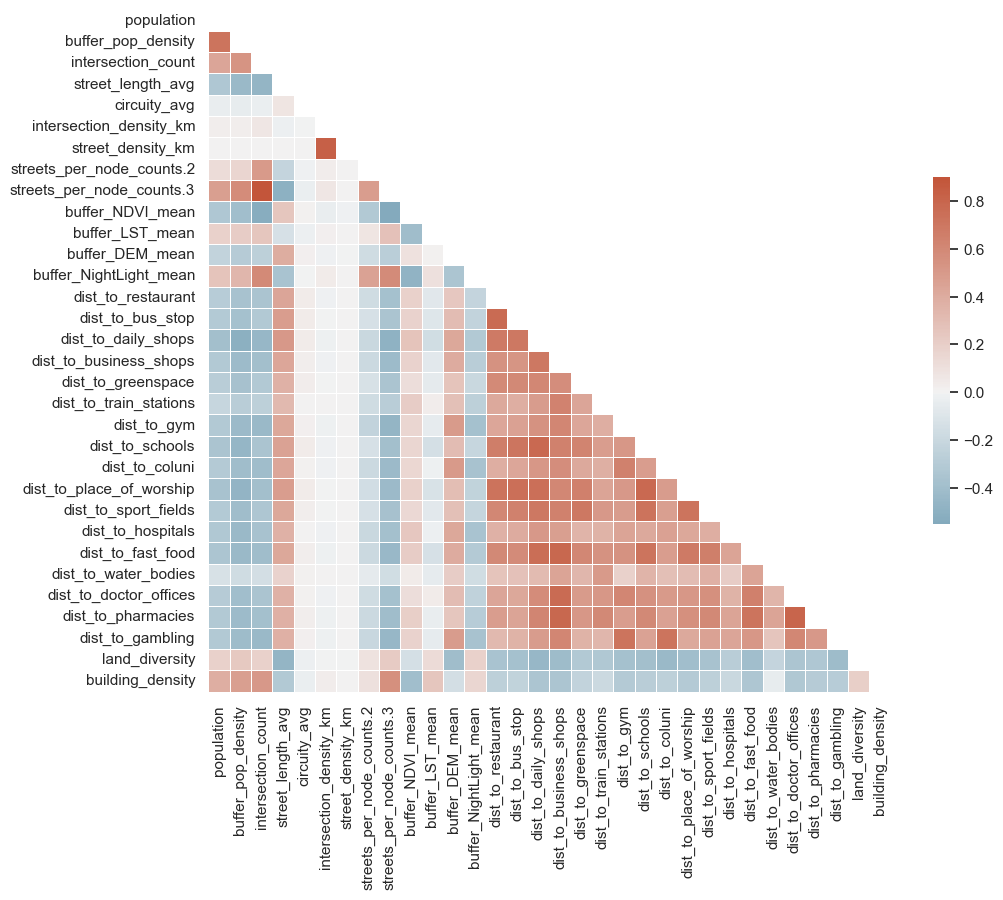

In [27]:
# correlation matrix of the variables
sb.set_theme(style="white")

# Compute the correlation matrix
corr = popgridsub[cluster_variables].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# subsetting to combine the vars that do not correlate and then use the subsets for hierarchical clustering


In [ ]:
# Using clustergram with hierarchical clustering up to 20 clusters
cgram = Clustergram(range(5, 21), method='hierarchical', linkage='ward')
cgram.fit(popgridsub_scaled)

# Plotting the clustergram
ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')

In [3]:
# goodness of fit tests for the amount of clusters
# We use the Silhouette and Calinski-Harabasz scores, higher is better for both

# Calinski-Harabasz score: the within-cluster variance divided by the between-cluster variance.
# Silhouette score: the average standardized distance from each observation to its “next best fit”
# cluster; the most similar cluster to which the observation is not currently assigned.

# plotting both the Silhouette score and the Calinski-Harabasz score per cluster amount
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
cgram.silhouette_score().plot(
    xlabel="Number of clusters (k)",
    ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
cgram.calinski_harabasz_score().plot(
    xlabel="Number of clusters (k)",
    ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

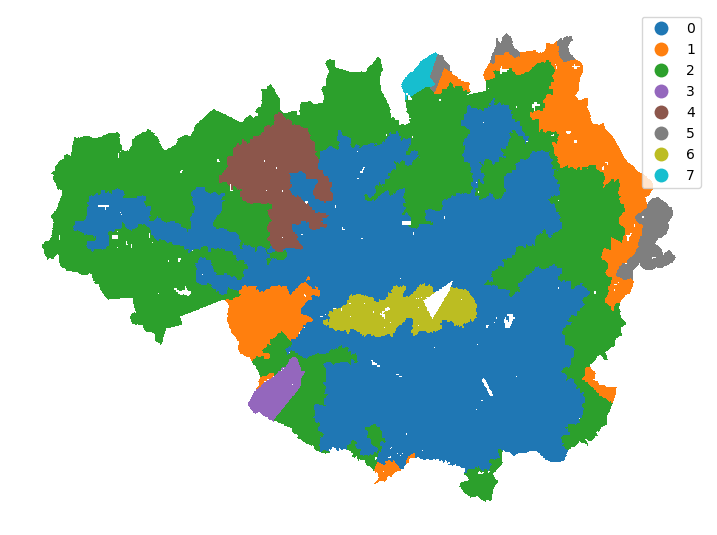

In [27]:
# plotting results
popgridsub["clustergram_label"] = cgram.labels[]
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="clustergram_label",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

### K-means clustering

In [ ]:
# Using clustergram with k-means clustering up to 20 clusters

# initial one to compensate kernel crashing due to parallelization
cgram = Clustergram(range(1, 2), n_init=1, method='kmeans')
# full one
cgram2 = Clustergram(range(1, 21), n_init=100, method='kmeans')

start_time = time.time()

if __name__ == '__main__':
    Parallel(n_jobs=2, prefer="threads")(delayed(cgram.fit)(popgridsub_scaled[:2]) for _ in range(1))
    Parallel(n_jobs=8, prefer="threads")(delayed(cgram2.fit)(popgridsub_scaled) for _ in range(1))

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

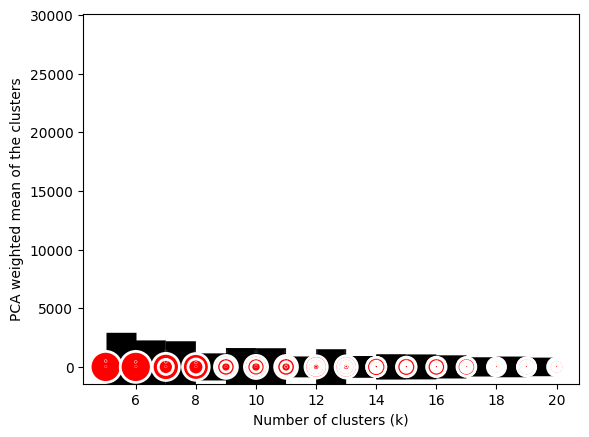

In [8]:
# plot cgram
cgram2.plot()

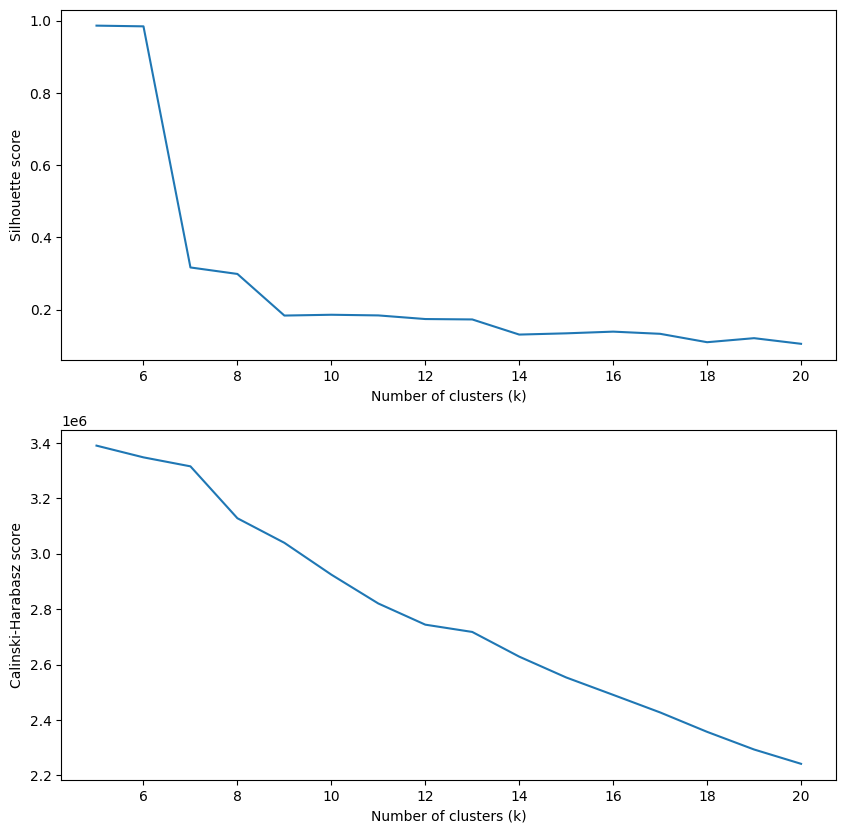

In [20]:
# Goodness of fit tests for the amount of clusters
# We use the Silhouette and Calinski-Harabasz scores, higher is better for both

# Calinski-Harabasz score: the within-cluster variance divided by the between-cluster variance.
# Silhouette score: the average standardized distance from each observation to its “next best fit”
# cluster; the most similar cluster to which the observation is not currently assigned.

# Define the function to compute the Calinski-Harabasz score
def compute_calinski_harabasz_score(clustergram):
    return clustergram.calinski_harabasz_score()

# Define the function to compute the silhouette score
def compute_silhouette_score(clustergram):
    return clustergram.silhouette_score()

# Compute the Calinski-Harabasz score in parallel
if __name__ == '__main__':
    Parallel(n_jobs=2, prefer="threads")(delayed(compute_calinski_harabasz_score)(cgram) for _ in range(1))
    Parallel(n_jobs=-1, prefer="threads")(delayed(compute_calinski_harabasz_score)(cgram2) for _ in range(1))

# Compute the silhouette score in parallel
if __name__ == '__main__':
    Parallel(n_jobs=2, prefer="threads")(delayed(compute_silhouette_score)(cgram) for _ in range(1))
    Parallel(n_jobs=-1, prefer="threads")(delayed(compute_silhouette_score)(cgram2) for _ in range(1))

# Plotting both the Silhouette score and the Calinski-Harabasz score per cluster amount
fig, axs = plt.subplots(2, figsize=(10, 10))
cgram2.silhouette.plot(xlabel="Number of clusters (k)", ylabel="Silhouette score", ax=axs[0])
cgram2.calinski_harabasz.plot(xlabel="Number of clusters (k)", ylabel="Calinski-Harabasz score", ax=axs[1])
plt.show()
#sb.despine(offset=10)

In [9]:
# save cgram
with open('clustergram.pickle','wb') as f:
    pickle.dump(cgram2, f)

In [ ]:
inertias = []
mapping = {}

K = range(1, 21)

def fit_kmeans(data, k):
    kmeanModel = KMeans(n_clusters=k, n_init=250)
    kmeanModel.fit(data)
    return kmeanModel.inertia_

if __name__ == '__main__':
    results = Parallel(n_jobs=2, prefer="threads")(delayed(fit_kmeans)(popgridsub_scaled[:2], k) for k in range(1,2))
    results = Parallel(n_jobs=-1, prefer="threads")(delayed(fit_kmeans)(popgridsub_scaled, k) for k in K)

inertias = results
mapping = dict(zip(K, results))

In [ ]:
# plotting elbow plot
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [17]:
inertias = []
mapping = {}

K = range(1, 21)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init=1000)
    kmeanModel.fit(popgridsub_scaled)
    # Check the inertia amount
    inertias.append(kmeanModel.inertia_)
    mapping[k] = kmeanModel.inertia_

/Users/Julian/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Julian/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Julian/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Julian/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

In [18]:
# Show inertia score per clusteramount
for key, val in mapping.items():
    print(f'{key} : {val}')

1 : 8351636.691695557
2 : 5494591.281866489
3 : 4681680.4010711415
4 : 4147823.706753294
5 : 3805918.845623615
6 : 3592321.0510536777
7 : 3404787.718989657
8 : 3273978.3985772966
9 : 3153074.6641536662


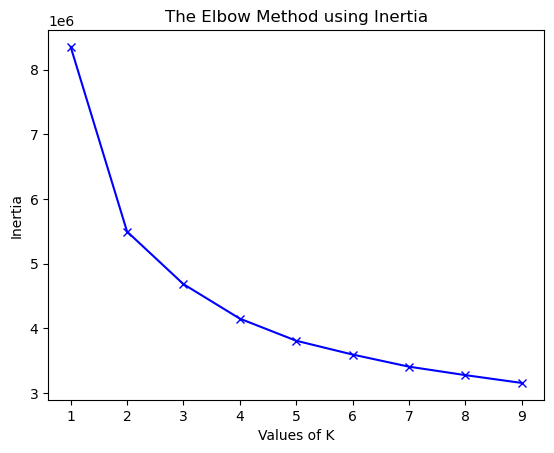

In [19]:
# plotting elbow plot
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [24]:
# model of 8 clusters
KmeanModel = KMeans(n_clusters=5, n_init=50)
kmeans = KmeanModel.fit(popgridsub_scaled)

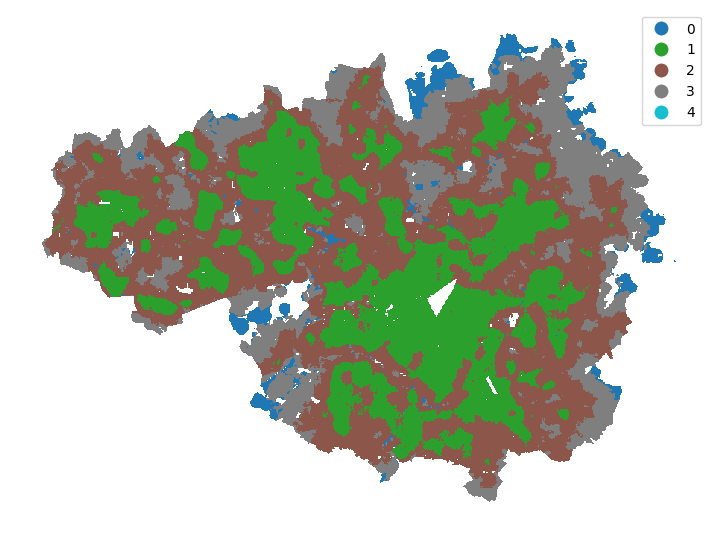

In [25]:
# plotting results
popgridsub["Kmeans_label"] = kmeans.labels_
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="Kmeans_label",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()